In [1]:
# RUN THESE COMMANDS IN THE TERMINAL THE FIRST TIME YOU OPEN THID NOTEBOOK!
# (this installs the required venv to the system so you can use it in jupyter)
# source .venv/bin/activate
# python -m ipykernel install --user --name=venn
# # Then select the kernel selction in the top right (it should say someting like Python ...) and choose "venv"

In [2]:
import torch
from transformers import AutoModelForCausalLM
from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
from Janus.janus.utils.io import load_pil_images

# specify the path to the model
# model_path = "/projectnb/cs598/projects/cool_proj/model"
# device = 'cuda'
model_path = '/Users/nover/models/deepseek-ai/Janus-Pro-7B'
device = 'mps'

vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).to(device).eval()


/Users/nover/repos/class/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/Users/nover/repos/class/.venv/lib/python3.12/site-packages/transformers/models/auto/image_processing_auto.py:593: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Python version is above 3.10, patching the collections module.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: mask_prompt, num_image_tokens, sft_format, 

In [3]:
@torch.inference_mode()
def generate(input_ids,
             width=384,
             height=384,
             temperature=1.0,
             num_images=5,
             cfg_weight=5.0,
             image_token_num_per_image=576,
             patch_size=16, 
             device='cuda'):
    """
    Generate image tokens and visual patches from the given input_ids.
    
    Parameters:
      input_ids (torch.LongTensor): The encoded prompt.
      width (int): Target width of the generated image (default 384).
      height (int): Target height of the generated image (default 384).
      temperature (float): Sampling temperature for generation (default 1.0).
      num_images (int): Number of image variations to generate (default 5).
      cfg_weight (float): Classifier-Free Guidance weight (default 5.0).
      image_token_num_per_image (int): Number of image tokens to generate per image (default 576).
      patch_size (int): Size of a single image patch (default 16).
      
    Returns:
      generated_tokens (torch.Tensor): The generated image tokens.
      patches (torch.Tensor): The decoded image patches.
    """
    # Clear CUDA cache to help avoid out-of-memory errors.
    if device == 'cuda':
        torch.cuda.empty_cache()
    
    # Create a tokens tensor with shape (num_images * 2, sequence_length)
    # The model expects paired tokens for unconditional and conditional generation.
    tokens = torch.zeros((num_images * 2, len(input_ids)), dtype=torch.int).to(device)
    for i in range(num_images * 2):
        tokens[i, :] = input_ids
        # For every odd-indexed row (the unconditional branch), replace
        # all tokens except the first and last with the pad token.
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    # Get the input embeddings for the tokens.
    inputs_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)
    
    # Prepare a tensor to hold the generated tokens.
    generated_tokens = torch.zeros((num_images, image_token_num_per_image), dtype=torch.int).to(device)
    pkv = None  # Past key values for caching.
    
    # Iteratively generate tokens for the image.
    for i in range(image_token_num_per_image):
        with torch.no_grad():
            outputs = vl_gpt.language_model.model(
                inputs_embeds=inputs_embeds,
                use_cache=True,
                past_key_values=pkv
            )
            pkv = outputs.past_key_values
            hidden_states = outputs.last_hidden_state
            # Get logits from the generation head.
            logits = vl_gpt.gen_head(hidden_states[:, -1, :])
            # Split logits into conditional and unconditional parts.
            logit_cond = logits[0::2, :]
            logit_uncond = logits[1::2, :]
            # Apply classifier-free guidance.
            logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
            # Convert logits to probabilities.
            probs = torch.softmax(logits / temperature, dim=-1)
            # Sample the next token.
            next_token = torch.multinomial(probs, num_samples=1)
            # Save the token for each image.
            generated_tokens[:, i] = next_token.squeeze(dim=-1)
            # Duplicate the sampled token for both branches and reshape.
            next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
            # Prepare new input embeddings for the next iteration.
            img_embeds = vl_gpt.prepare_gen_img_embeds(next_token)
            inputs_embeds = img_embeds.unsqueeze(dim=1)
    
    # Decode the generated tokens into image patches.
    patches = vl_gpt.gen_vision_model.decode_code(
        generated_tokens.to(dtype=torch.int),
        shape=[num_images, 8, width // patch_size, height // patch_size]
    )
    
    return generated_tokens.to(dtype=torch.int), patches

In [4]:
import torch
import numpy as np
from PIL import Image

# Assume these globals are already defined and loaded:
#   - vl_gpt: the loaded Janus-Pro model (AutoModelForCausalLM)
#   - vl_chat_processor: the VLChatProcessor for formatting conversations
#   - tokenizer: the corresponding tokenizer
#   - device: device string ("cuda" if available else "cpu")
#
# Also assume helper functions `generate` and `unpack` are defined as in the demo.

import torch
import numpy as np
from PIL import Image

import torch
import numpy as np
from PIL import Image

# --- Assume these exist in your namespace ---
# vl_gpt, vl_chat_processor, tokenizer

def set_seed(seed: int):
    """
    Set random seeds for reproducibility.
    """
    if device == 'cuda':
        torch.cuda.empty_cache()
    torch.manual_seed(seed)
    np.random.seed(seed)
    if device == 'cuda':
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)


def generate_text_output(
    vl_chat_processor,
    input_text: str,
    input_image,
    device: str,
    seed: int,
    top_p: float,
    temperature: float,
):
    """
    Generate text output given optional image context.
    Returns: str
    """
    if input_text is None:
        raise ValueError("Text input is required for text output.")

    # Seed environment for reproducible results
    if seed is not None: set_seed(seed)

    # If an image is provided, we do multimodal text generation
    if input_image is not None:
        conversation = [
            {
                "role": "<|User|>",
                "content": f"<image_placeholder>\n{input_text}",
                "images": [input_image],
            },
            {"role": "<|Assistant|>", "content": ""},
        ]
        # Convert numpy array to PIL if needed
        pil_images = [Image.fromarray(input_image)] if isinstance(input_image, np.ndarray) else [input_image]
        prep = vl_chat_processor(conversations=conversation, images=pil_images, force_batchify=True)
        t_dtype = torch.bfloat16 if torch.cuda.is_available() or torch.mps.is_available() else torch.float16
        prep = prep.to(device, dtype=t_dtype)

        inputs_embeds = vl_gpt.prepare_inputs_embeds(**prep)
        outputs = vl_gpt.language_model.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=prep.attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=512,
            do_sample=(temperature != 0),
            use_cache=True,
            temperature=temperature,
            top_p=top_p,
        )
        return tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
    else:
        # Pure text generation
        inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
        outputs = vl_gpt.generate(
            inputs,
            max_new_tokens=512,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
        )
        return tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)


def generate_image_output(
    vl_chat_processor,
    input_text: str,
    input_image,
    device: str,
    seed: int,
    guidance: float,
    t2i_temperature: float,
    num_images: int,
    width: int,
    height: int,
    out_width: int,
    out_height: int,
    image_token_num_per_image: int,
    patch_size: int,
):
    """
    Generate images conditioned on text (and optionally on an image).
    Returns: list of PIL.Image
    """
    if input_text is None:
        raise ValueError("Text prompt is required for image generation.")

    # Seed environment for reproducible results
    if seed is not None: set_seed(seed)

    with torch.inference_mode():
        # Build the prompt
        if input_image is not None:
            conversation = [
                {
                    "role": "<|User|>",
                    "content": f"<image_placeholder>\n{input_text}",
                    "images": [input_image],
                },
                {"role": "<|Assistant|>", "content": ""},
            ]
            prep = vl_chat_processor(conversations=conversation, images=[input_image], force_batchify=True)
            prompt = prep.sft_format[0] + vl_chat_processor.image_start_tag
        else:
            messages = [
                {"role": "<|User|>", "content": input_text},
                {"role": "<|Assistant|>", "content": ""},
            ]
            sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
                conversations=messages,
                sft_format=vl_chat_processor.sft_format,
                system_prompt=""
            )
            prompt = sft_format + vl_chat_processor.image_start_tag

        input_ids = torch.LongTensor(tokenizer.encode(prompt)).to(device)

        # Prepare unconditional/conditional tokens
        tokens = torch.zeros((num_images * 2, len(input_ids)), dtype=torch.int).to(device)
        for i in range(num_images * 2):
            tokens[i, :] = input_ids
            # Unconditional branch: pad the middle tokens
            if i % 2 != 0:
                tokens[i, 1:-1] = vl_chat_processor.pad_id
        
        # Convert tokens to embeddings
        inputs_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)

        # Generate tokens for the image patches
        generated_tokens = torch.zeros((num_images, image_token_num_per_image), dtype=torch.int).to(device)
        pkv = None
        for i in range(image_token_num_per_image):
            outputs = vl_gpt.language_model.model(
                inputs_embeds=inputs_embeds,
                use_cache=True,
                past_key_values=pkv
            )
            pkv = outputs.past_key_values
            hidden_states = outputs.last_hidden_state

            # Classifier-free guidance
            logits = vl_gpt.gen_head(hidden_states[:, -1, :])
            logit_cond = logits[0::2, :]
            logit_uncond = logits[1::2, :]
            logits = logit_uncond + guidance * (logit_cond - logit_uncond)

            # Sample next token
            probs = torch.softmax(logits / t2i_temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated_tokens[:, i] = next_token.squeeze(dim=-1)

            # Prepare next input embeddings
            next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
            img_embeds = vl_gpt.prepare_gen_img_embeds(next_token)
            inputs_embeds = img_embeds.unsqueeze(dim=1)
        
        # Convert tokens to image patches
        patches = vl_gpt.gen_vision_model.decode_code(
            generated_tokens.to(torch.int),
            shape=[num_images, 8, width // patch_size, height // patch_size]
        )
        patches = patches.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)
        patches = np.clip((patches + 1) / 2 * 255, 0, 255).astype(np.uint8)

        # Resize images to desired resolution
        out_images = [
            Image.fromarray(patches[i]).resize((out_width, out_height), Image.LANCZOS)
            for i in range(num_images)
        ]
        return out_images


def janus_pro_generate(
    vl_chat_processor,
    input_text=None,
    input_image=None,
    device='cuda',
    output_mode="text",
    seed=None,
    top_p=0.95,
    temperature=0.1,
    guidance=5,
    t2i_temperature=1.0,
    num_images=5,
    width=384,
    height=384,
    out_width=768,
    out_height=768,
    image_token_num_per_image=576,
    patch_size=16,
):
    """
    Unified entry point for Janus-Pro that dispatches to text or image generation.
    """
    if seed is None:
        seed = np.random.randint(1)
    if output_mode == "text":
        return generate_text_output(
            vl_chat_processor,
            input_text=input_text,
            input_image=input_image,
            device=device,
            seed=seed,
            top_p=top_p,
            temperature=temperature
        )
    elif output_mode == "image":
        return generate_image_output(
            vl_chat_processor,
            input_text=input_text,
            input_image=input_image,
            device=device,
            seed=seed,
            guidance=guidance,
            t2i_temperature=t2i_temperature,
            num_images=num_images,
            width=width,
            height=height,
            out_width=out_width,
            out_height=out_height,
            image_token_num_per_image=image_token_num_per_image,
            patch_size=patch_size
        )
    else:
        raise ValueError("output_mode must be either 'text' or 'image'.")



In [8]:
# from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
# model_path = "/projectnb/cs598/projects/cool_proj/model"

text_prompt = 'make this image a meme'

# # Load the image from a file
image = Image.open("img.jpg")
chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
# tokenizer = vl_chat_processor.tokenizer

# Call the unified function for multimodal understanding (text output)
result = janus_pro_generate(
    chat_processor,
    device=device,
    input_text=text_prompt,
    input_image=image,
    output_mode="image",
    guidance=5,
    t2i_temperature=1.0,
    num_images=1,
    # width=192,
    # height=192,
)




Some kwargs in processor config are unused and will not have any effect: mask_prompt, num_image_tokens, sft_format, ignore_id, image_tag, add_special_token. 


RuntimeError: shape '[1, 12, 12, 8]' is invalid for input of size 4608

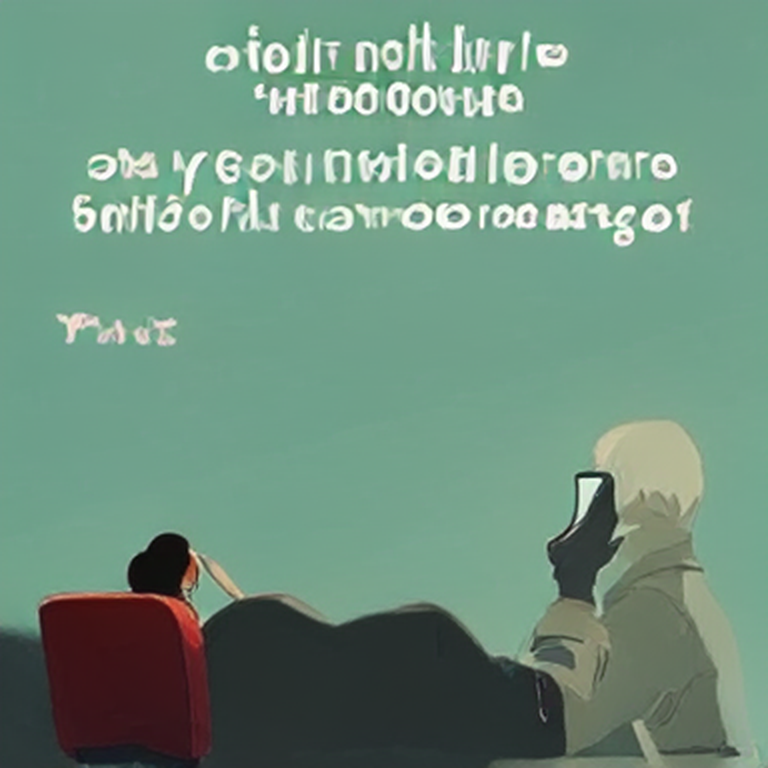

Generated Text Response:


In [7]:
# Save generated images to disk.
for idx, img in enumerate(result):
    display(img)


# Print the generated text response
print("Generated Text Response:")